In [1]:
import numpy as np
import csv, os
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pandas as pd

TRAIN_PATH = "../data/train.csv"
VALID_PATH = "../data/test.csv"

In [2]:
# gradient decent
def GD(X, Y, ω, η, Iteration, λ): 
    """
    使用gradient decent learning rate 要調很小，不然很容易爆炸
    """
    listCost = []
    for itera in range(Iteration):
        arrayYHat = X.dot(ω)
        arrayLoss = arrayYHat - Y
        arrayCost = np.sqrt(np.mean(arrayLoss**2))
        listCost.append(arrayCost)

        arrayGradient = (X.T.dot(arrayLoss) / X.shape[0]) + (λ * ω)
        ω -= η * arrayGradient
        if itera % 1000 == 0:
            print("iteration:{}, cost:{} ".format(itera, arrayCost))
    return ω, listCost

In [3]:
# Adagrad
def Adagrad(X, Y, ω, η, Iteration, λ):
    listCost = []
    arrayGradientSum = np.zeros((X.shape[1],1))
    for itera in range(Iteration):
        arrayYHat = np.dot(X, ω)
        arrayLoss = arrayYHat - Y
        arrayCost = np.sqrt(np.mean(arrayLoss**2))

        # save cost function value in process
        listCost.append(arrayCost)

        arrayGradient = (np.dot(np.transpose(X), arrayLoss) / X.shape[0]) + (λ * ω)
        arrayGradientSum += arrayGradient**2
        arraySigma = np.sqrt(arrayGradientSum)
        ω -= η * arrayGradient / arraySigma

        if itera % 1000 == 0:
            print("iteration:{}, cost:{} ".format(itera, arrayCost))
    return ω, listCost

In [4]:
###---DataProcessing---###
# 讀進訓練資料
data = pd.read_csv(TRAIN_PATH, encoding='big5')  ## Read data
data.drop(columns=data.columns[:3], inplace=True) ## Remove first three columns
data.replace('NR', 0, inplace=True)             ## Replace NR to 0
data = data.astype(np.float)
data = data.to_numpy()
data[data<0] = 0

# 切分訓練資料
month_data = {}
for month in range(12):
    sample = np.empty([18, 480]) 
    # 將資料排程 Row -> 特徵, Col -> 時間
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample
    
listTrainX = np.empty([12 * 471, 18 * 9], dtype = float)
listTrainY = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            # 每個月只有 20 天的訓練資料，後面幾個小時無法使用
            if day == 19 and hour > 14:
                continue
            listTrainX[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            listTrainY[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value

# 正規化訓練資料
mean_x = np.mean(listTrainX, axis=0) #18 * 9 
std_x = np.std(listTrainX, axis=0) #18 * 9 
max_x = np.max(listTrainX, axis=0)
min_x = np.min(listTrainX, axis=0)

for i in range(len(listTrainX)): #12 * 471
    for j in range(len(listTrainX[0])): #18 * 9 
        if std_x[j] != 0:
            listTrainX[i][j] = (listTrainX[i][j] - mean_x[j]) / std_x[j]
#             listTrainX[i][j] = (listTrainX[i][j] - min_x[j]) / (max_x[j] - min_x[j])

    
# 讀進測試資料
data = pd.read_csv(VALID_PATH, header = None, encoding = 'big5')
data = data.iloc[:, 2:]
data[data == 'NR'] = 0
data = data.astype(np.float)
data = data.to_numpy()

listTestX = np.empty([240, 18*9], dtype = float)
for i in range(240):
    listTestX[i, :] = data[18 * i: 18* (i + 1), :].reshape(1, -1)
    
listTestX[listTestX < 0] = 0

    
for i in range(len(listTestX)):
    for j in range(len(listTestX[0])):
        if std_x[j] != 0:
            listTestX[i][j] = (listTestX[i][j] - mean_x[j]) / std_x[j]
#             listTestX[i][j] = (listTestX[i][j] - min_x[j]) / (max_x[j] - min_x[j])
            
arrayTestX = np.array(listTestX)
arrayTrainX = np.array(listTrainX)
arrayTrainY = np.array(listTrainY)

# 增加bias項
arrayTrainX = np.insert(arrayTrainX, arrayTrainX.shape[1], values=1, axis=1) # (5652, 163)
arrayTestX = np.insert(arrayTestX, arrayTestX.shape[1], values=1, axis=1) # (5652, 163)

In [5]:
###---Train---###
# gradient decent
intLearningRate = 5e-2
arrayW = np.zeros((arrayTrainX.shape[1],1))  # (163, )
arrayW_gd, listCost_gd = GD(X=arrayTrainX, Y=arrayTrainY, ω=arrayW, η=intLearningRate, Iteration=20000, λ=0)
arrayW = np.zeros((arrayTrainX.shape[1],1))  # (163, )
arrayW_gd_1, listCost_gd_1 = GD(X=arrayTrainX, Y=arrayTrainY, ω=arrayW, η=intLearningRate, Iteration=20000, λ=5e-4)
# Adagrad
intLearningRate = 1.27
arrayW = np.zeros((arrayTrainX.shape[1],1))  # (163, )
arrayW_ada, listCost_ada = Adagrad(X=arrayTrainX, Y=arrayTrainY, ω=arrayW, η=intLearningRate, Iteration=20000, λ=0)
# close form
arrayW_cf = inv(arrayTrainX.T.dot(arrayTrainX)).dot(arrayTrainX.T.dot(arrayTrainY))

iteration:0, cost:27.071044901246307 
iteration:1000, cost:5.717948394018365 
iteration:2000, cost:5.675703671881644 
iteration:3000, cost:5.669104701845864 
iteration:4000, cost:5.667063102402785 
iteration:5000, cost:5.6659148969483635 
iteration:6000, cost:5.665103250000143 
iteration:7000, cost:5.664490611165529 
iteration:8000, cost:5.6640151303486554 
iteration:9000, cost:5.66363881330134 
iteration:10000, cost:5.663335936712798 
iteration:11000, cost:5.663088502829983 
iteration:12000, cost:5.662883685904889 
iteration:13000, cost:5.662712202151468 
iteration:14000, cost:5.6625672262062645 
iteration:15000, cost:5.662443658777244 
iteration:16000, cost:5.662337626573857 
iteration:17000, cost:5.662246137937608 
iteration:18000, cost:5.662166843730243 
iteration:19000, cost:5.662097869861807 
iteration:0, cost:27.071044901246307 
iteration:1000, cost:5.720090228184034 
iteration:2000, cost:5.677252613249189 
iteration:3000, cost:5.67009993139151 
iteration:4000, cost:5.6678252073

In [11]:
###---Test---###
# gradient decent
arrayPredictY_gd = np.dot(arrayTestX, arrayW_gd)
# Adagrad
arrayPredictY_ada = np.dot(arrayTestX, arrayW_ada)
# close form
arrayPredictY_cf = np.dot(arrayTestX, arrayW_cf)

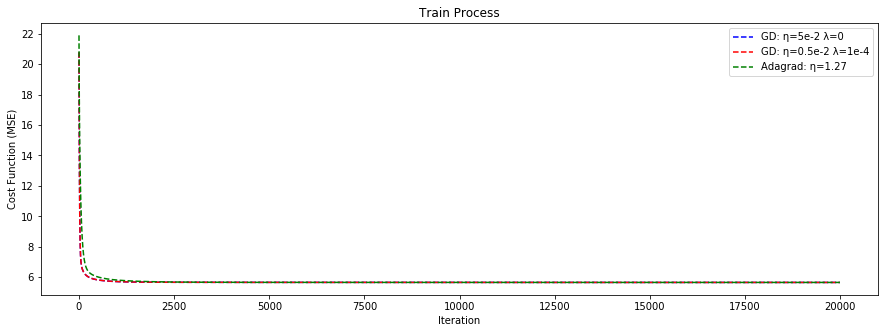

In [12]:
###---Visualization---###
plt.figure(figsize=(15, 5))
plt.plot(np.arange(len(listCost_gd[3:])), listCost_gd[3:], "b--", label="GD: η=5e-2 λ=0")
plt.plot(np.arange(len(listCost_gd_1[3:])), listCost_gd_1[3:], "r--", label="GD: η=0.5e-2 λ=1e-4")
plt.plot(np.arange(len(listCost_ada[3:])), listCost_ada[3:], "g--", label="Adagrad: η=1.27")
plt.title("Train Process")
plt.xlabel("Iteration")
plt.ylabel("Cost Function (MSE)")
plt.legend()
plt.savefig("../Output/TrainProcess")
plt.show()


In [13]:
# compare predict value with different methods
dcitD = {"Adagrad":[arrayPredictY_ada], "CloseForm":[arrayPredictY_cf], "GD":[arrayPredictY_gd]}
pdResult = pd.DataFrame(dcitD)
print(pdResult["Adagrad"])

0    [[6.528668231831256], [18.51585999855544], [24...
Name: Adagrad, dtype: object


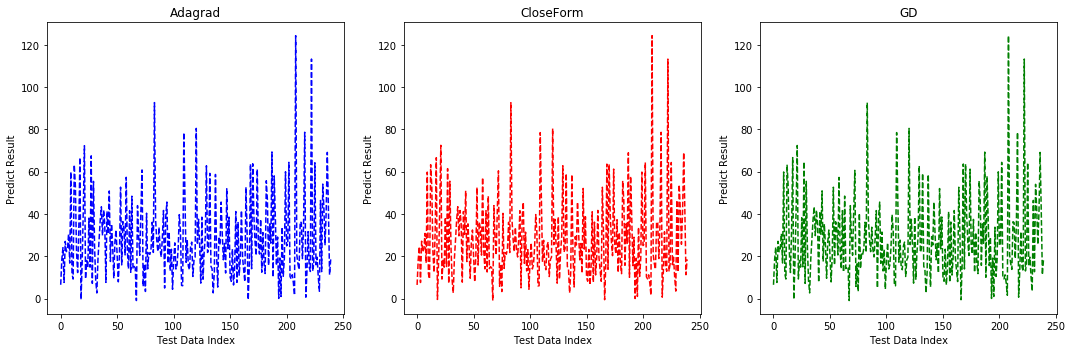

In [14]:
# visualize predict value with different methods
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(np.arange(len(arrayPredictY_ada)), arrayPredictY_ada, "b--")
plt.title("Adagrad")
plt.xlabel("Test Data Index")
plt.ylabel("Predict Result")

plt.subplot(132)
plt.plot(np.arange(len(arrayPredictY_cf)), arrayPredictY_cf, "r--")
plt.title("CloseForm")
plt.xlabel("Test Data Index")
plt.ylabel("Predict Result")

plt.subplot(133)
plt.plot(np.arange(len(arrayPredictY_gd)), arrayPredictY_gd, "g--")
plt.title("GD")
plt.xlabel("Test Data Index")
plt.ylabel("Predict Result")

plt.tight_layout()
plt.savefig("../Output/Compare.png")
plt.show()

In [16]:
import csv
def SaveResult(writePath, result):
    with open(writePath, mode='w', newline='') as submit_file:
        csv_writer = csv.writer(submit_file)
        header = ['id', 'value']
        print(header)
        csv_writer.writerow(header)
        for i in range(240):
            row = ['id_' + str(i), result[i][0]]
            csv_writer.writerow(row)
            print(row)

arrayPredictY_gd[arrayPredictY_gd<0]=0
arrayPredictY_ada[arrayPredictY_ada<0]=0
SaveResult('../Output/submit_gd.csv', np.round(arrayPredictY_gd))
SaveResult('../Output/submit_ada.csv', np.round(arrayPredictY_ada))

['id', 'value']
['id_0', 7.0]
['id_1', 18.0]
['id_2', 24.0]
['id_3', 8.0]
['id_4', 27.0]
['id_5', 22.0]
['id_6', 24.0]
['id_7', 31.0]
['id_8', 17.0]
['id_9', 60.0]
['id_10', 12.0]
['id_11', 9.0]
['id_12', 63.0]
['id_13', 53.0]
['id_14', 22.0]
['id_15', 12.0]
['id_16', 32.0]
['id_17', 67.0]
['id_18', 0.0]
['id_19', 17.0]
['id_20', 42.0]
['id_21', 72.0]
['id_22', 9.0]
['id_23', 18.0]
['id_24', 15.0]
['id_25', 38.0]
['id_26', 15.0]
['id_27', 65.0]
['id_28', 7.0]
['id_29', 55.0]
['id_30', 24.0]
['id_31', 9.0]
['id_32', 3.0]
['id_33', 19.0]
['id_34', 28.0]
['id_35', 37.0]
['id_36', 43.0]
['id_37', 30.0]
['id_38', 42.0]
['id_39', 35.0]
['id_40', 8.0]
['id_41', 41.0]
['id_42', 30.0]
['id_43', 51.0]
['id_44', 18.0]
['id_45', 35.0]
['id_46', 25.0]
['id_47', 10.0]
['id_48', 27.0]
['id_49', 32.0]
['id_50', 20.0]
['id_51', 8.0]
['id_52', 20.0]
['id_53', 53.0]
['id_54', 16.0]
['id_55', 36.0]
['id_56', 33.0]
['id_57', 21.0]
['id_58', 57.0]
['id_59', 23.0]
['id_60', 14.0]
['id_61', 42.0]
['id_62', 13